In [1]:
# Import libraries
import pickle
import requests
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fastai.tabular.all as fastai
np.set_printoptions(linewidth=130)
import torch

load_dotenv()
key = os.getenv('API_KEY')
api_url = "http://api.positionstack.com/v1/forward"

longLats = pickle.load(open('./longLat.pkl', 'rb'))
len(longLats)

# clean up data: area, date, floor, price
def load_csv():
  #return pd.read_csv('./data/Woodlands_June22_May23.csv')
  return pd.read_csv('./data/resale-flat-from-jan-2017.csv')
floor_dict = { f'0{i*3+1} TO 0{i*3+3}' if i < 3 else f'{i*3+1} TO {i*3+3}': i*3+2  for i in range(17)  }
def floor_cleanup(df):
  df['floor'] = df.storey_range.apply(lambda x:float(floor_dict[x]) if isinstance(x,str) else x)
  df.drop(['storey_range'], axis=1, inplace=True)
  return df
date_dict = { f'20{17+i}-0{j+1}' if j < 9 else f'20{17+i}-{j+1}': i*12+j  for i in range(7) for j in range(12)  }
def date_cleanup(df):
  df['date'] = df.month.apply(lambda x:float(date_dict[x]) if isinstance(x,str) else x)
  df.drop(['month'], axis=1, inplace=True)
  return df
def load_and_cleanup():
  df = load_csv()
  df = floor_cleanup(df)
  df = date_cleanup(df)
  return df

df = load_and_cleanup()
df.describe()
date_max = df.date.max()
df = df[(df.town=="SEMBAWANG") & (df.date > date_max-12)]

from pathlib import Path
file = Path('./data/Sembawang_June22_May23.csv')
df.to_csv(file,index=False)
df


,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
129065,SEMBAWANG,2 ROOM,130B,CANBERRA CRES,47.0,Model A,2018,95 years 05 months,334000.0,11.0,65.0
129066,SEMBAWANG,2 ROOM,130A,CANBERRA CRES,38.0,Model A,2018,95 years 05 months,325000.0,11.0,65.0
129067,SEMBAWANG,3 ROOM,130A,CANBERRA CRES,68.0,Model A,2018,95 years 05 months,452000.0,8.0,65.0
129068,SEMBAWANG,3 ROOM,130A,CANBERRA CRES,68.0,Model A,2018,95 years 05 months,405000.0,2.0,65.0
129069,SEMBAWANG,3 ROOM,104D,CANBERRA ST,68.0,Model A,2018,95 years 01 month,450000.0,14.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
153428,SEMBAWANG,5 ROOM,329,SEMBAWANG CL,115.0,Improved,1999,75 years 03 months,608000.0,11.0,76.0
153429,SEMBAWANG,5 ROOM,407,SEMBAWANG DR,110.0,Improved,2001,77 years,535000.0,8.0,76.0
153430,SEMBAWANG,5 ROOM,473,SEMBAWANG DR,110.0,Improved,2000,76 years 06 months,529000.0,2.0,76.0
153431,SEMBAWANG,EXECUTIVE,416,CANBERRA RD,130.0,Apartment,2001,76 years 11 months,730000.0,11.0,76.0


In [2]:
blk_street = df.block + ' ' + df.street_name

responses = []
for i,add in enumerate(blk_street.unique()):
  response = requests.get(f"{api_url}?access_key={key}&query={add}+singapore")
  responses.append(response.json())
  first_response = response.json()['data'][0]
  if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
    longLats[f"{add}"] = (first_response['longitude'], first_response['latitude'])
    if (i%10==0):
      print(f"{first_response['label']}, confidence {first_response['confidence']}, {i} of {len(blk_street.unique())}")
  else:
    print(f"check {add}. {first_response['label']}. confidence of {first_response['confidence']}")

pickle.dump(longLats, open('./longLat.pkl', 'wb'))
len(longLats)


check 365A SEMBAWANG CRES. Singapore. confidence of 0.6
check 365B SEMBAWANG CRES. Singapore. confidence of 0.6
check 366A SEMBAWANG CRES. Singapore. confidence of 0.6
check 365C SEMBAWANG CRES. Singapore. confidence of 0.6


1771

In [3]:
errors = [
  "365A SEMBAWANG CRES",
  "365B SEMBAWANG CRES",
  "365C SEMBAWANG CRES",
  "366A SEMBAWANG CRES",
]
len(errors)

4

In [4]:
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
129065,SEMBAWANG,2 ROOM,130B,CANBERRA CRES,47.0,Model A,2018,95 years 05 months,334000.0,11.0,65.0
129066,SEMBAWANG,2 ROOM,130A,CANBERRA CRES,38.0,Model A,2018,95 years 05 months,325000.0,11.0,65.0
129067,SEMBAWANG,3 ROOM,130A,CANBERRA CRES,68.0,Model A,2018,95 years 05 months,452000.0,8.0,65.0
129068,SEMBAWANG,3 ROOM,130A,CANBERRA CRES,68.0,Model A,2018,95 years 05 months,405000.0,2.0,65.0
129069,SEMBAWANG,3 ROOM,104D,CANBERRA ST,68.0,Model A,2018,95 years 01 month,450000.0,14.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
153428,SEMBAWANG,5 ROOM,329,SEMBAWANG CL,115.0,Improved,1999,75 years 03 months,608000.0,11.0,76.0
153429,SEMBAWANG,5 ROOM,407,SEMBAWANG DR,110.0,Improved,2001,77 years,535000.0,8.0,76.0
153430,SEMBAWANG,5 ROOM,473,SEMBAWANG DR,110.0,Improved,2000,76 years 06 months,529000.0,2.0,76.0
153431,SEMBAWANG,EXECUTIVE,416,CANBERRA RD,130.0,Apartment,2001,76 years 11 months,730000.0,11.0,76.0


In [8]:
dfL = df[(~df.block.str.startswith('365'))&(~df.block.str.startswith('366'))]
file = Path('./data/Sembawang_June22_May23_without_newest.csv')
dfL.to_csv(file,index=False)
dfL

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
129065,SEMBAWANG,2 ROOM,130B,CANBERRA CRES,47.0,Model A,2018,95 years 05 months,334000.0,11.0,65.0
129066,SEMBAWANG,2 ROOM,130A,CANBERRA CRES,38.0,Model A,2018,95 years 05 months,325000.0,11.0,65.0
129067,SEMBAWANG,3 ROOM,130A,CANBERRA CRES,68.0,Model A,2018,95 years 05 months,452000.0,8.0,65.0
129068,SEMBAWANG,3 ROOM,130A,CANBERRA CRES,68.0,Model A,2018,95 years 05 months,405000.0,2.0,65.0
129069,SEMBAWANG,3 ROOM,104D,CANBERRA ST,68.0,Model A,2018,95 years 01 month,450000.0,14.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
153428,SEMBAWANG,5 ROOM,329,SEMBAWANG CL,115.0,Improved,1999,75 years 03 months,608000.0,11.0,76.0
153429,SEMBAWANG,5 ROOM,407,SEMBAWANG DR,110.0,Improved,2001,77 years,535000.0,8.0,76.0
153430,SEMBAWANG,5 ROOM,473,SEMBAWANG DR,110.0,Improved,2000,76 years 06 months,529000.0,2.0,76.0
153431,SEMBAWANG,EXECUTIVE,416,CANBERRA RD,130.0,Apartment,2001,76 years 11 months,730000.0,11.0,76.0


In [9]:
df[(df.block.str.startswith('365'))|(df.block.str.startswith('366'))].describe()

,floor_area_sqm,lease_commence_date,resale_price,floor,date
count,10.000000,10.0,10.00000,10.000000,10.000000
mean,72.500000,2019.0,463300.00000,9.500000,75.300000
std,22.416512,0.0,108581.81759,4.301163,0.674949
min,48.000000,2019.0,330000.00000,2.000000,74.000000
25%,48.000000,2019.0,349750.00000,5.750000,75.000000
50%,80.500000,2019.0,495000.00000,11.000000,75.000000
75%,93.000000,2019.0,552500.00000,13.250000,76.000000
max,93.000000,2019.0,600000.00000,14.000000,76.000000


In [10]:
df = pd.read_csv('./data/Sembawang_June22_May23_without_newest.csv')
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
0,SEMBAWANG,2 ROOM,130B,CANBERRA CRES,47.0,Model A,2018,95 years 05 months,334000.0,11.0,65.0
1,SEMBAWANG,2 ROOM,130A,CANBERRA CRES,38.0,Model A,2018,95 years 05 months,325000.0,11.0,65.0
2,SEMBAWANG,3 ROOM,130A,CANBERRA CRES,68.0,Model A,2018,95 years 05 months,452000.0,8.0,65.0
3,SEMBAWANG,3 ROOM,130A,CANBERRA CRES,68.0,Model A,2018,95 years 05 months,405000.0,2.0,65.0
4,SEMBAWANG,3 ROOM,104D,CANBERRA ST,68.0,Model A,2018,95 years 01 month,450000.0,14.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
871,SEMBAWANG,5 ROOM,329,SEMBAWANG CL,115.0,Improved,1999,75 years 03 months,608000.0,11.0,76.0
872,SEMBAWANG,5 ROOM,407,SEMBAWANG DR,110.0,Improved,2001,77 years,535000.0,8.0,76.0
873,SEMBAWANG,5 ROOM,473,SEMBAWANG DR,110.0,Improved,2000,76 years 06 months,529000.0,2.0,76.0
874,SEMBAWANG,EXECUTIVE,416,CANBERRA RD,130.0,Apartment,2001,76 years 11 months,730000.0,11.0,76.0


In [11]:
def lat_long(df):
  adds = (df.block + ' ' + df.street_name)
  longLat = adds.apply(lambda x: longLats[x])
  df['long'] = longLat.apply(lambda x: x[0])
  df['lat'] = longLat.apply(lambda x: x[1])
  return df
lat_long(df)
df.describe()

,floor_area_sqm,lease_commence_date,resale_price,floor,date,long,lat
count,876.000000,876.000000,876.000000,876.000000,876.000000,876.000000,876.000000
mean,95.878995,2010.085616,531876.904110,8.270548,70.611872,103.824940,1.448959
std,22.021371,8.371146,103710.442763,4.076817,3.249973,0.007472,0.003257
min,38.000000,1998.000000,255000.000000,2.000000,65.000000,103.813074,1.444405
25%,90.750000,2001.000000,460000.000000,5.000000,68.000000,103.817254,1.446475
50%,93.000000,2015.000000,535000.000000,8.000000,71.000000,103.826597,1.448565
75%,111.000000,2018.000000,598000.000000,11.000000,73.000000,103.832092,1.450921
max,142.000000,2019.000000,795000.000000,20.000000,76.000000,103.834038,1.456732


In [12]:
dls = fastai.TabularDataLoaders.from_df(df,procs=[fastai.Normalize],cont_names=["floor", "floor_area_sqm", "lease_commence_date", "date", "lat","long"],y_names=["resale_price"])
dls.show_batch()

,floor,floor_area_sqm,lease_commence_date,date,lat,long,resale_price
0,2.0,46.999999,2018.0,69.0,1.444995,103.833138,343000.0
1,2.0,93.000000,2018.0,71.0,1.449274,103.833359,492000.0
2,5.0,101.000000,1999.0,75.0,1.445488,103.819397,488688.0
3,5.0,93.000000,2018.0,73.0,1.447461,103.831825,550000.0
4,11.0,93.000000,2018.0,67.0,1.447461,103.831825,585000.0
5,5.0,46.999999,2018.0,74.0,1.445670,103.833786,333000.0
6,8.0,66.999999,2018.0,75.0,1.449274,103.833359,430000.0
7,2.0,111.000000,2001.0,65.0,1.449951,103.816559,475000.0
8,11.0,123.000001,1999.0,74.0,1.445688,103.819031,610000.0
9,11.0,120.000001,1999.0,68.0,1.444472,103.821030,570000.0


SuggestedLRs(valley=0.0014454397605732083, slide=6.309573450380412e-07)

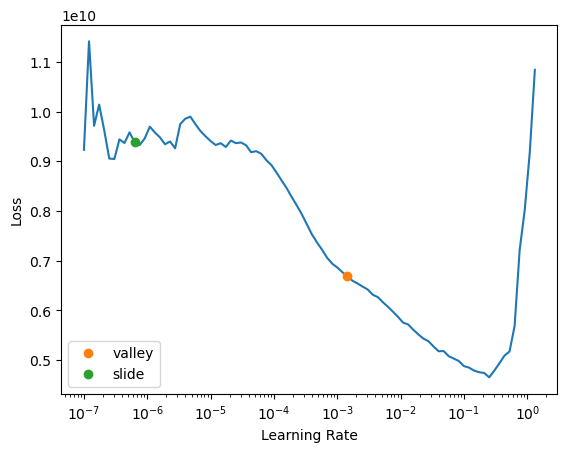

In [13]:
def MSE(yhat,y):
  return torch.mean(torch.square(yhat-y))
def RMSE(yhat,y):
  return torch.sqrt(MSE(yhat,y))
learn = fastai.tabular_learner(dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),loss_func=MSE,metrics=RMSE)
learn.lr_find(suggest_funcs=(fastai.valley,fastai.slide))


In [18]:
learn = fastai.tabular_learner(
  dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),
  loss_func=MSE,metrics=RMSE,
  cbs=[fastai.SaveModelCallback(),fastai.EarlyStoppingCallback(patience=5)]
)
learn.fit_one_cycle(100,8e-2)
learn.validate()


Better model found at epoch 0 with valid_loss value: 24513.265625.


(#2) [609028864.0,24513.265625]

In [15]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 24841.34765625.


(#2) [619719744.0,24841.34765625]

In [19]:
# predict prices on map
row = df.drop(['resale_price'], axis=1).iloc[0].copy()
cats = ['floor', 'floor_area_sqm', 'lease_commence_date', 'date']
for cat in cats:
  row[cat] = df[cat].median()
latMin, latMax = df.lat.min(),df.lat.max()
latLeft = latMin - (latMax-latMin)/10
latRight = latMax + (latMax-latMin)/10
longMin, longMax = df.long.min(),df.long.max()
longLeft = longMin - (longMax-longMin)/10
longRight = longMax + (longMax-longMin)/10
n1 = 16*10
n2 = 11*10
longs = np.linspace(longLeft, longRight, n1)
lats = np.linspace(latLeft, latRight, n2)
prices = np.ndarray((n2,n1))
for i,lat in enumerate(lats):
  print(f"{i} of {n1}")
  row['lat'] = lat
  for j,long in enumerate(longs):
    row['long'] = long
    _, yPred, _ = learn.predict(row)
    prices[i][j] = yPred.item()

In [23]:
import http.client, urllib.parse
import json

mrts = ["Canberra MRT", "Sembawang MRT"]

longLat = pickle.load(open('./longLat.pkl', 'rb'))
print(f"pkl loaded. {len(longLats)}")

responses = []
for mrt in mrts:
    conn = http.client.HTTPConnection('api.positionstack.com')
    params = urllib.parse.urlencode({
        'access_key': key,
        'query': mrt[:-4] + ' Station',
        'region': 'Singapore',
        'limit': 1,
    })
    conn.request('GET', '/v1/forward?{}'.format(params))
    res = conn.getresponse()
    data = res.read()
    first_response = json.loads(data.decode('utf-8'))['data'][0]
    responses.append(first_response)
    if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
        longLats[f"{mrt}"] = (first_response['longitude'], first_response['latitude'])
        print(f"{first_response['label']}, confidence {first_response['confidence']}")
    else:
        print(f"check {mrt}. {first_response['label']}. confidence of {first_response['confidence']}")

pickle.dump(longLats, open('./longLat.pkl', 'wb'))
len(longLats)


pkl loaded. 1773
Canberra Station, Singapore, confidence 1
Sembawang Station, Singapore, confidence 1


1773

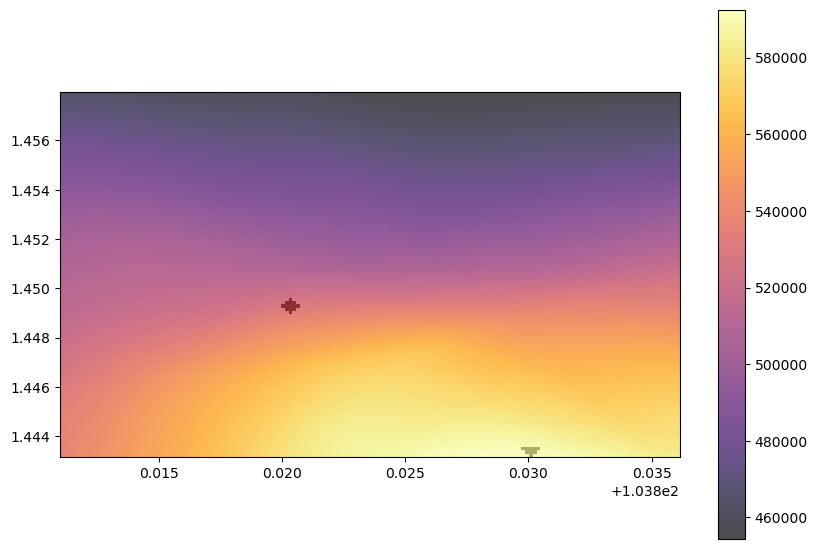

In [27]:
def min_coords(long,lat):
  return (np.abs((longs-long)).argmin(), np.abs(lats-lat).argmin())
mrt_map = np.zeros((n2,n1))
#mrts = ["Yio Chu Kang MRT", "Ang Mo Kio MRT"]
#for mrt in mrts:
#  (i,j) = min_coords(*longLats[mrt])
#  #for m in range(3):
#  #  for n in range(3):
#  mrt_map[j+m-1][i+n-1] = 1

(i,j) = min_coords(*longLats[mrts[0]])
mrt_map[j+2][i]=1
mrt_map[j+2][i-1]=1
mrt_map[j+2][i+1]=1
mrt_map[j+2][i-2]=1
mrt_map[j+2][i+2]=1
mrt_map[j+1][i]=1
mrt_map[j+1][i-1]=1
mrt_map[j+1][i+1]=1
mrt_map[j][i]=1
#mrt_map[j-1][i]=1
#mrt_map[j][i-1]=1
#mrt_map[j][i+1]=1
#mrt_map[j+1][i-2]=1
#mrt_map[j+1][i-1]=1
#mrt_map[j+1][i+2]=1
#mrt_map[j+1][i+1]=1
#mrt_map[j+1][i]=1

"""
(i,j) = min_coords(*longLats[mrts[0]])
mrt_map[j+1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j-1][i-2]=1
mrt_map[j-1][i-1]=1
mrt_map[j-1][i+2]=1
mrt_map[j-1][i+1]=1
mrt_map[j-1][i]=1
(i,j) = min_coords(*longLats[mrts[0]])
mrt_map[j-2][i+1]=1
mrt_map[j-1][i+1]=1
mrt_map[j-1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j+1][i]=1
mrt_map[j+1][i+1]=1
mrt_map[j+2][i+1]=1
(i,j) = min_coords(*longLats[mrts[2]])
mrt_map[j-2][i-1]=1
mrt_map[j-1][i-1]=1
mrt_map[j-1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j+1][i]=1
mrt_map[j+1][i-1]=1
mrt_map[j+2][i-1]=1
"""
(i,j) = min_coords(*longLats[mrts[1]])
mrt_map[j+1][i]=1
mrt_map[j+1][i-1]=1
mrt_map[j+1][i+1]=1
mrt_map[j-1][i]=1
mrt_map[j-1][i+1]=1
mrt_map[j-1][i-1]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j][i-2]=1
mrt_map[j][i+2]=1
mrt_map[j+2][i]=1
mrt_map[j-2][i]=1

fig,ax=plt.subplots()
#mrt
#color map
shw2 = ax.imshow(mrt_map, extent=[longLeft, longRight, latLeft, latRight], origin='lower',cmap='Greys',alpha=1.0)
shw = ax.imshow(prices, extent=[longLeft, longRight, latLeft, latRight], origin='lower',alpha=0.7, cmap='inferno')
bar = plt.colorbar(shw)
fig.set_figwidth(10)
fig.set_figheight(10/n1*n2)

plt.show()

In [50]:
longLeft,longRight

(103.8288214, 103.8619606)

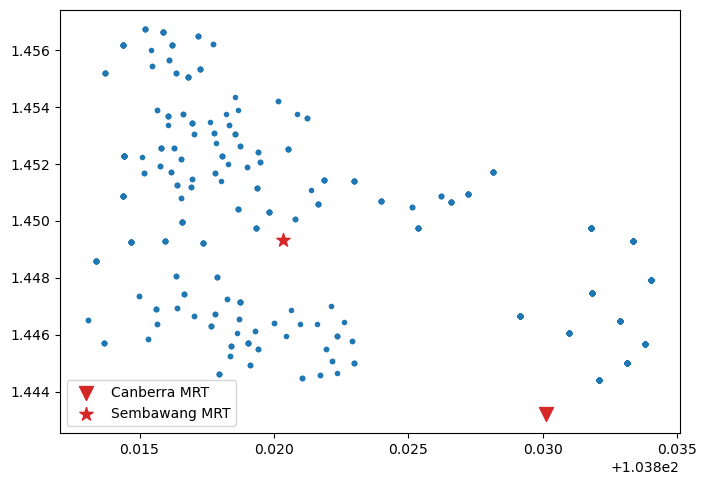

In [28]:
markers = ["v", "*"]

fig,ax2=plt.subplots()
ax2.scatter(df.long,df.lat,marker='.')
for i,mrt in enumerate(mrts):
  ax2.scatter([longLats[mrt][0]], [longLats[mrt][1]],marker=markers[i],c='#d62728',label=mrt,s=100)
ax2.legend(loc='lower left')
fig.set_figwidth(8)
fig.set_figheight(8/n1*n2)

plt.show()


for mrt in mrts:
  (i,j) = min_coords(*longLats[mrt])
